<h3 style='text-align: right;'> Geophysics Independent Project </h3>

## Notebook 4: Correct for the instrumental response

You're now in a position to download seismic data, filter it to periods you're interested in, and analyse some of the results.  However, the data you've analysed so far is just _what comes out of the seismometer._  The thing you're interested in is _what goes into the seismometer: the ground shaking._  And the instrument does modify the signal a bit.  In this notebook, you'll learn to correct the seismic data for that modification to recover the ground shaking.

In [1]:
import numpy as np 
import obspy
import matplotlib.pyplot as plt

### 1. What is the Instrument Response

Seismometers are designed to observe ground motion.  In an ideal world, the output of the seismometer would simply be the displacement or velocity of the ground as a function of time.  But how to record that motion?  

The general approach is to compare the relative motion of two bodies: (1) a frame that's firmly attached to the Earth and (2) a  heavy mass that is poorly attached to the Earth.  In the image below, provided by IRIS, the frame and rotating drum will move along with the Earth.  But the heavy mass with the attached pen are attached to the Earth only via the spring, so their motion will be delayed and damped relative to Earth's motion.  By observing the relative motion of the drum and pen, you can then back out the motion of the Earth.

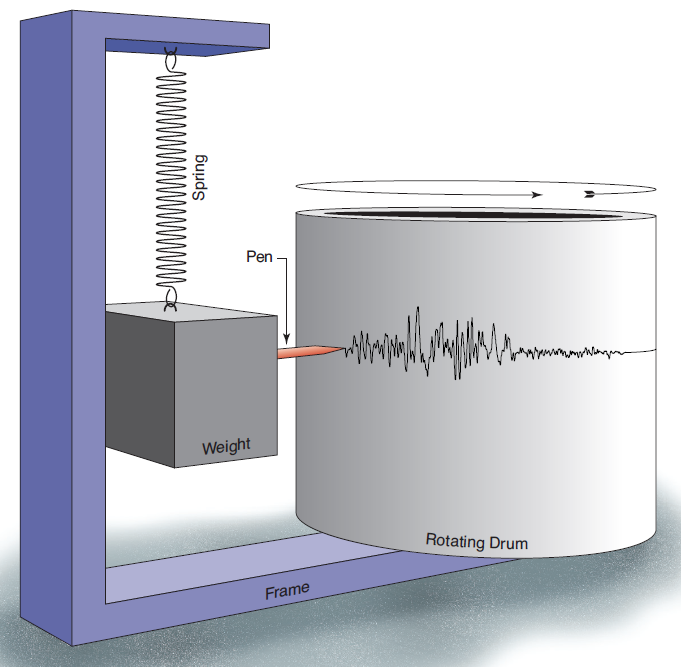

To back out the Earth's motion, however, we need to know something about the spring.  You need to know how the relative motion between the mass and the drum reponds when the Earth moves at different periods.  You might imagine three regimes:

- if you moved the ground very slowly, the spring wouldn't oscillate much.  It'd always stay extended about the same amount, and the weight would always say the same distance from the frame; you wouldn't observe any relative motion .  If you moved the ground back and forth very quickly, the spring wouldn't have time to extend or contract
- if you moved the ground very quickly, the spring might not have time to tell the mass to move.  In this case, the mass would be stationary, and the ground, frame, and drum would move around it.  The relative motion between the drum and mass would be the true motion of the Earth.
- if you moved the ground back and forth at what happens to be the resonance period of the spring, you might get a large response.  The mass could start an amplified oscillation, and the relative motion could be _bigger_ than the motion of the Earth.

The response function may thus look something like the below.


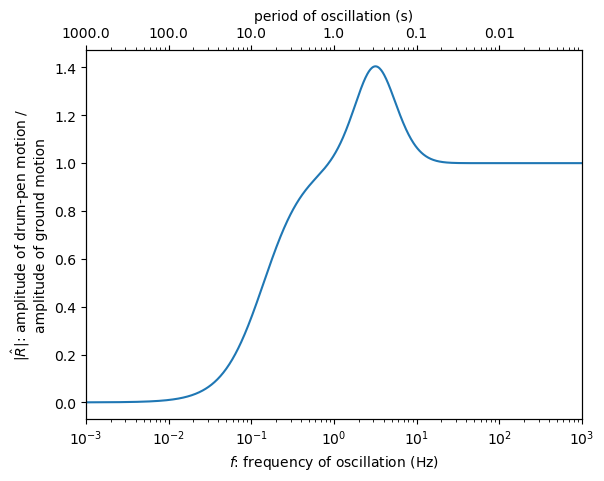

In [7]:
freq=np.logspace(-3,3,1000)
amp = 1/(1 + 100*np.exp(-4*(2+np.log10(freq))))
amp = np.multiply(0.5*amp,1+np.exp(.6*np.exp(-np.power((np.log10(freq)-.5)/.4,2))))

plt.semilogx(freq,amp)
plt.ylabel('|$\\hat{R}$|: amplitude of drum-pen motion /\namplitude of ground motion')
plt.xlabel('$f$: frequency of oscillation (Hz)')
plt.xlim([np.min(freq),np.max(freq)])
ax=plt.twiny(plt.gca())
ax.xaxis.tick_top()
ax.set_xlim([np.min(freq),np.max(freq)])
xtck=np.power(10,np.arange(np.log10(np.min(freq)),np.log10(np.max(freq))))
ax.set_xscale('log')
ax.set_xticks(xtck)
ax.set_xticklabels(np.power(xtck,-1));
ax.set_xlabel('period of oscillation (s)');


Note, howevever, that seismometers no longer have literal springs anymore.   Nowadays the moving mass in a seismometer is modulated by a magnetic field which adjusts and observes the mass location.  As a result, there's less variation in the instrumental response; usually there's no peak.  But there's still no ability for the seismometer to observe variations in ground motion at very long periods.  The response function may look something like the below.

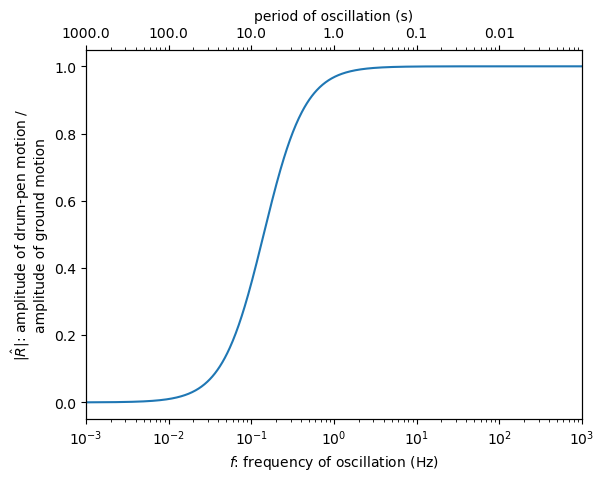

In [6]:
freq=np.logspace(-3,3,1000)
amp = 1/(1 + 100*np.exp(-4*(2+np.log10(freq))))

plt.semilogx(freq,amp)
plt.ylabel('|$\\hat{R}$|: amplitude of drum-pen motion /\namplitude of ground motion')
plt.xlabel('$f$: frequency of oscillation (Hz)')
plt.xlim([np.min(freq),np.max(freq)])
ax=plt.twiny(plt.gca())
ax.xaxis.tick_top()
ax.set_xlim([np.min(freq),np.max(freq)])
xtck=np.power(10,np.arange(np.log10(np.min(freq)),np.log10(np.max(freq))))
ax.set_xscale('log')
ax.set_xticks(xtck)
ax.set_xticklabels(np.power(xtck,-1));
ax.set_xlabel('period of oscillation (s)');


### 2. Playing with response functions

Before we move on to real seismic data, let's write a plausible response function mathematically and see what sort of behaviours we might get from it.  The direct output of the seismometer is the convolution of the ground motion and the instrumental response.

$$\textrm{seismometer output} = \textrm{ground motion} \ast \textrm{instrumental response}$$

Each of these functions can be written in the time or the frequency domain, as you'll recall from time series analysis.
In the time domain, with time $t$, we have a convolution:

$$O(t) = d(t) \ast R(t).$$

In the frequency domain, we have a simple multiplication, albeit of complex numbers.

$$\hat{O}(f) = \hat{d}(f) \hat{R}(f).$$


Let's say the true ground motion $d(t)$ is a the sum of two sinusoids, one with a 2-s period and one with a 20-s period, like the below.

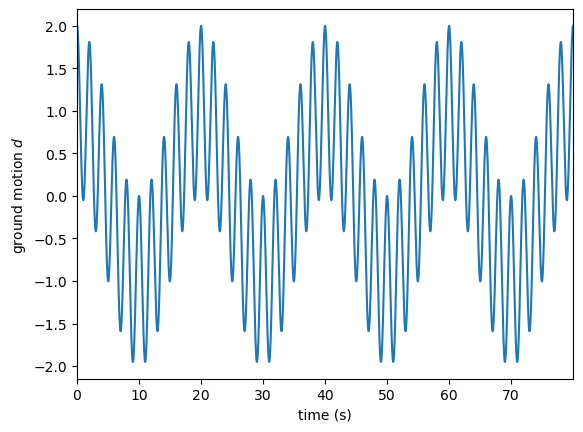

In [8]:
# define time
t=np.arange(0,80,0.01)

# and ground motion
d=np.cos(t/2.*(2*np.pi))+np.cos(t/20.*(2*np.pi))

plt.plot(t,d);
plt.xlabel('time (s)');
plt.ylabel('ground motion $d$');
plt.xlim([np.min(t),np.max(t)]);

We can convolve this ground motion with the instrumental response to determine the voltage output by the seismometer.  We'll use the same response amplitude as defined in the last cell of section 1.

In [9]:
# move to the frequency domain
dhat=np.fft.rfft(d)

# note the relevant frequencies
freq=np.fft.rfftfreq(d.size,d=np.median(np.diff(t)))

# define the response in the frequency domain
Rhat = np.zeros(freq.size)
ii=freq>0
Rhat[ii] = 1/(1 + 100*np.exp(-4*(2+np.log10(freq[ii]))))


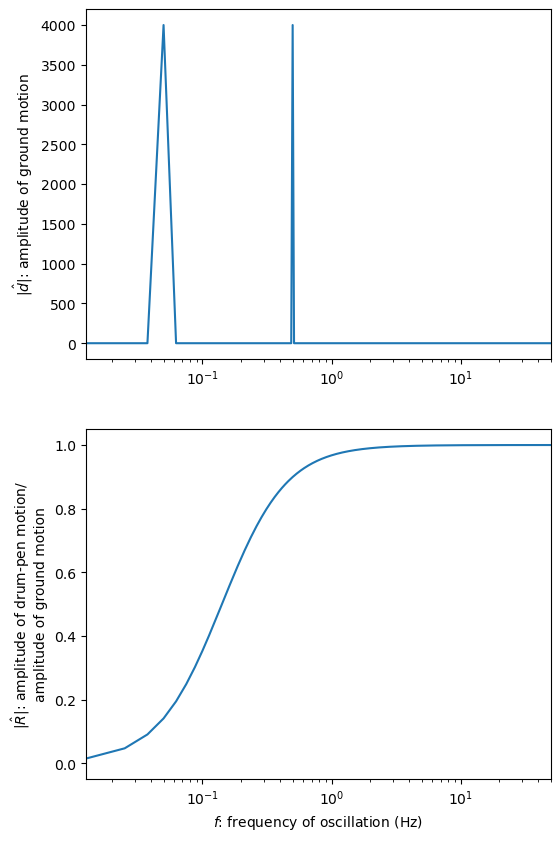

In [11]:
# first let's just plot the amplitudes of the true ground motion and instrument response in the frequency domain
plt.figure(figsize=(6,10))

plt.subplot(2,1,1)
plt.semilogx(freq,np.abs(dhat))
plt.ylabel('|$\\hat{d}$|: amplitude of ground motion')
#plt.xlabel('$f$: frequency of oscillation (Hz)')
plt.xlim([np.min(freq[ii]),np.max(freq[ii])])

plt.subplot(2,1,2)
plt.semilogx(freq,np.abs(Rhat))
plt.ylabel('|$\\hat{R}$|: amplitude of drum-pen motion/\namplitude of ground motion')
plt.xlabel('$f$: frequency of oscillation (Hz)')
plt.xlim([np.min(freq[ii]),np.max(freq[ii])]);

In [14]:
# and then do the convolution (multiplication in the frequency domain) to determine the seismometer output
Ohat=np.multiply(dhat,Rhat)

# back to the time domain
O=np.fft.irfft(Ohat)

We can look at the amplitude of the output oscillations in the frequency domain.

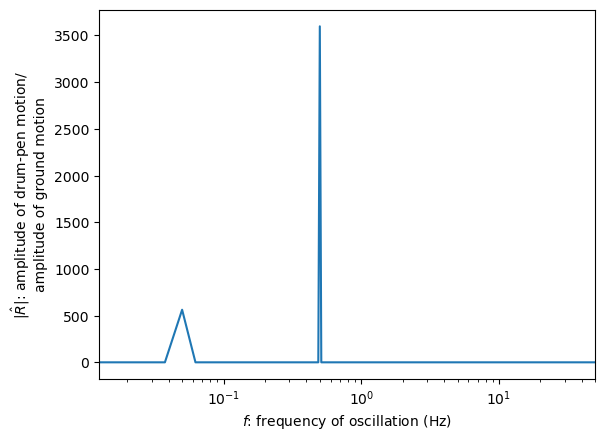

In [16]:
plt.semilogx(freq,np.abs(Ohat))
plt.ylabel('|$\\hat{R}$|: amplitude of drum-pen motion/\namplitude of ground motion')
plt.xlabel('$f$: frequency of oscillation (Hz)')
plt.xlim([np.min(freq[ii]),np.max(freq[ii])]);

And we can compare the time series of the true ground motion with the seismometer output.

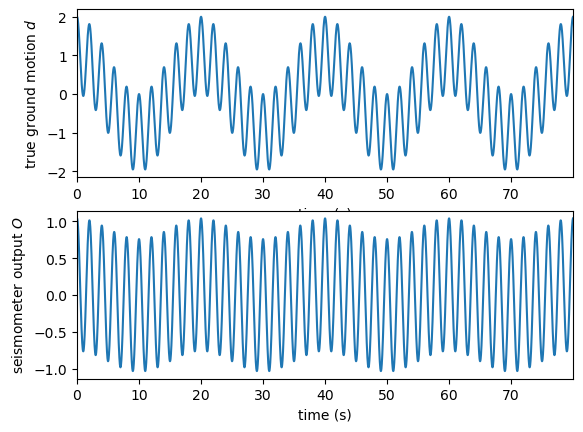

In [18]:
plt.subplot(2,1,1)
plt.plot(t,d);
plt.xlabel('time (s)');
plt.ylabel('true ground motion $d$');
plt.xlim([np.min(t),np.max(t)]);

plt.subplot(2,1,2)
plt.plot(t,O);
plt.xlabel('time (s)');
plt.ylabel('seismometer output $O$');
plt.xlim([np.min(t),np.max(t)]);

_Q1: How do the true ground motion and the seismometer output differ?  Why?_

Your answer here.

_Q2: Modify the code above to change the input periods of oscillation to 1 and 0.5 s.  Then recompute.  What happens?  Why?_

Your answer here.

### 3. Removing the response function

If we know the true ground motion and the response function, it thus seems straightforward to simulate what the seismometer will output.  But that's not what we know; we know the seismometer output and the response function.

_Q3: Say the seismometer output and the response function are as in the cell below.  Compute the true ground motion.  Plot it.  Nicely---it's good practice to make pretty, readable, and well-labelled plots._

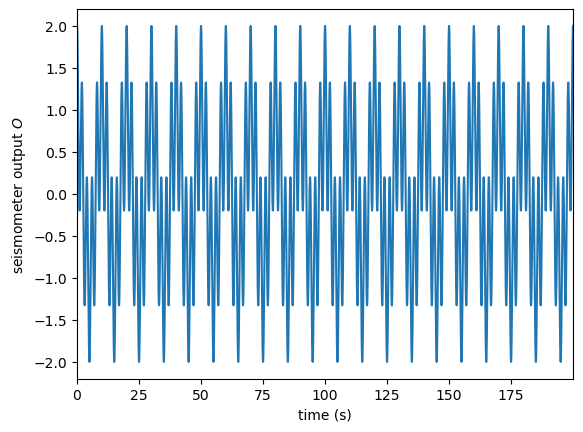

In [19]:
# define time
t=np.arange(0,200,0.01)

# and seismometer output
O=np.cos(t/2.*(2*np.pi))+np.cos(t/10.*(2*np.pi))

plt.plot(t,O);
plt.xlabel('time (s)');
plt.ylabel('seismometer output $O$');
plt.xlim([np.min(t),np.max(t)]);

In [20]:
# move to the frequency domain
Ohat=np.fft.rfft(O)

# note the relevant frequencies
freq=np.fft.rfftfreq(O.size,d=np.median(np.diff(t)))

# define the response in the frequency domain
Rhat = np.zeros(freq.size)
ii=freq>0
Rhat[ii] = 1/(1 + 100*np.exp(-4*(2+np.log10(freq[ii]))))


In [21]:
# compute the true ground motion in the frequency domain
# your code here

# and compute the true ground motion in the time domain
# your code here

# plot
# your code here

_Q4. What happens if you try to correct a seismometer output that has a very long period of oscillation---say 80s?  How much might you trust the corrected ground motion at that period---in this synthetic scenario and in the real world?_

Your answer here.

### 4. Downloading a response function

Now that we know how response functions work, we can move on to real data.  Our first step is to find the response function for the station of interest.  If we're using obspy's FDSN access protocols, this is simple, and we have two options.   In both cases, we first need to open a link to the server and decide which time and station to consider.  Let's consider the same stations as before.



In [22]:
# this line creates a shortcut to the function obspy.clients.fdsn.client.Client
from obspy.clients.fdsn.client import Client

# and this line calls the function Client to establish a connection to IRIS.
client = Client("IRIS")

# next, let's determine which time window we want: just after a M7.6 earthquake in Mexico

# start on the 27th of February 2010, at 6:30 am UTC
t1 = obspy.UTCDateTime(2022,9,19,18,5,8)

# and finish 10 minutes, or 600 seconds later
t2 = t1 + 1800

#### Option 1. Download the response when we download the waveform, so it's attached.
Summarized here: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html

In [23]:
# we'll look for data from network IU, station COR, located in Oregon state
st1 = client.get_waveforms("IU", "COR", "60", "BHZ", t1, t2,attach_response=True)
print(st1)

1 Trace(s) in Stream:
IU.COR.60.BHZ | 2022-09-19T18:05:08.019538Z - 2022-09-19T18:35:07.969538Z | 20.0 Hz, 36000 samples


Take a look at some of the information stored within one of the trace objects.

In [24]:
# grab the first (and only) trace
tr=st1[0]

# tr.data stores the seismic data
print('here''s the data:',tr.data,'\n')

# tr.stats stores a bunch of stuff (that's not data)
print('and some other stuff')
print(tr.stats)

heres the data: [ -1013   -951   -889 ... -32073 -31973 -31845] 

and some other stuff
               network: IU
               station: COR
              location: 60
               channel: BHZ
             starttime: 2022-09-19T18:05:08.019538Z
               endtime: 2022-09-19T18:35:07.969538Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 36000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 153, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 78336})
            processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2022, 9, 19, 18, 35, 8, 19538)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2022, 9, 19, 18, 5, 8, 19538))']
              response: Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Over

In [25]:
# we're interested in the response
print(tr.stats.response)

Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.43824e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 3429
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 419430
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


This response is a set of amplitudes (and phases) as a function of frequency, as was $\hat{R}$ about.  But it's not saved that way.  The response is saved in two parts.  One is the gain, or sensitivty, which describes the overall amplitude of the instrument, independent of amplitude.  The other part is the frequency dependence, which is given as a few numbers---the poles and zeros.  Obspy knows how to convert these poles, zeros, and sensivity to a response function as a function of frequency or time. 

The first panel below is $|\hat{R}$|, as we defined above.  The second panel is the phase of $\hat{R}$: 
$tan^{-1} (real(\hat{R})/imag(\hat{R}) ) $.  It determines whether the oscillations output by the seismometer are timed in sync with the input ground motion.  Above we've assumed they were: that the phase of $\hat{R}$ was always zero, so that the response could change the amplitude of a sinusoid but couldn't shift it forward or backward in time.

_Q5: The reponse at the station below is roughly flat between 0.005 Hz and 10 Hz.  What does that mean from a practical perspective?  For example, do you think this station is good at recording ground motion at periods of 10 or 100s?_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


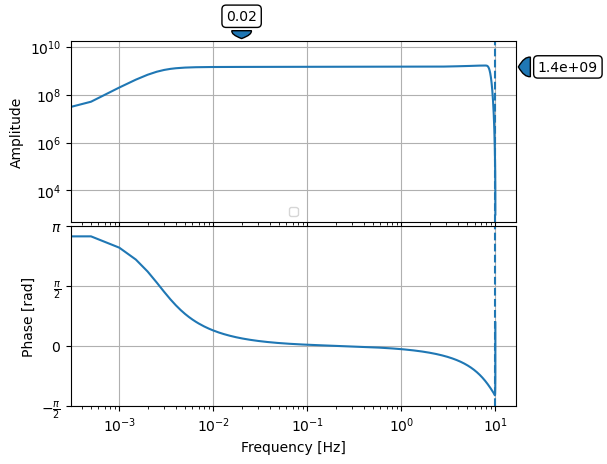

In [26]:
tr.stats.response.plot(min_freq=0.0005);

_Q6:  Let's look at another station.  Do you think this station is good at recording ground motion at periods of 10 or 100 s?_

Your answer here

In [27]:
# we'll look for data from a station installed in a borehole, 100m below ground, also in Oregon
st2 = client.get_waveforms("PB", "B028", "*", "EHZ", t1, t2,attach_response=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


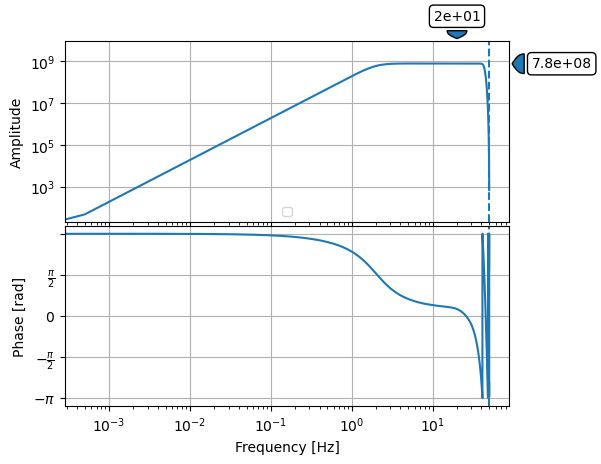

In [28]:
st2.select(channel='*Z')[0].stats.response.plot(min_freq=0.0005);

#### Option 2. Download the response when we ask which stations are available.
Summarized here: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html 

In case we don't want to download them at the same time as the waveforms, we can also just download the response directly.  This might be useful if we want to download data from many time intervals but the response isn't changing.

In [29]:
# get an inventory for the first, broadband station
inventory1 = client.get_stations(network="IU", station="COR",channel='BHZ',location='60',
                                starttime=t1,endtime=t2,level='response')
print(inventory1)

Inventory created at 2025-04-11T13:46:25.286700Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-09-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (1):
			IU.COR (Corvallis, Oregon, USA)
		Channels (1):
			IU.COR.60.BHZ


In [31]:
# get an inventory for the second, higher frequency station
inventory2 = client.get_stations(network="PB", station="B028",channel='EHZ',location='*',
                                starttime=t1,endtime=t2,level='response')
print(inventory2)

Inventory created at 2025-04-11T13:46:37.889700Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-09-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			PB
		Stations (1):
			PB.B028 (lester028bor2007, Albany, OR, USA)
		Channels (1):
			PB.B028..EHZ


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Here is the channel of interest
Channel 'BHZ', Location '60' 
	Time range: 2020-10-27T18:55:00.000000Z - --
	Latitude: 44.5855, Longitude: -123.3046, Elevation: 110.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 20.00 Hz
	Sensor (Description): None (Streckeisen STS-1VBB w/E300)
	Response information available

Here is the response
Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.43824e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 3429
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 419430
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


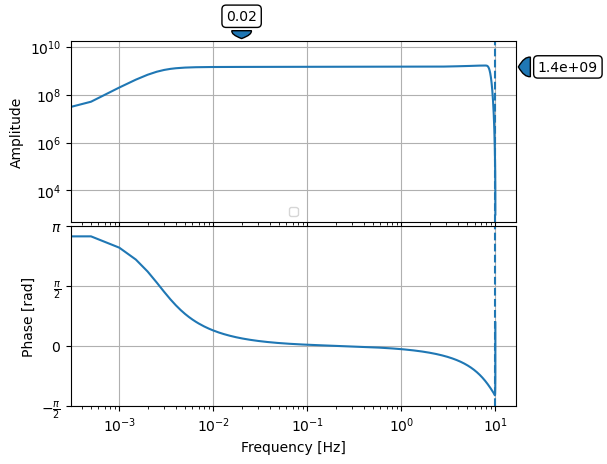

In [32]:
# the inventory is a set of networks, which contains a set of stations, which contains a set of channels
# so if we want the response for the first (and only) channel at the first (and only) station 
# at the first (and only) network, in inventory1, we extract
invi=inventory1[0][0][0]
print('Here is the channel of interest')
print(invi)

print('\nHere is the response')
print(invi.response)

# and again we can plot it
invi.response.plot(min_freq=0.0005);


#### 5. Side note: what information can you grab from a Python variable?

We've noted above that the invi object has a property called "response." We can extract that property and look at it.

In [34]:
print(invi.response)

Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.43824e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 3429
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 419430
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


But what if we didn't know which properties invi had?  Or maybe we forgot the exact details, or how to spell "response"?  To find out the properties that belong to a given object, you can always type "dir(object)".

_Q7: Try typing dir(invi) below and play around a bit.  Can you figure out where station IU.COR is located?_

In [35]:
dir(invi)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_alternate_code',
 '_azimuth',
 '_clock_drift_in_seconds_per_sample',
 '_code',
 '_depth',
 '_dip',
 '_elevation',
 '_equipments',
 '_historical_code',
 '_identifiers',
 '_latitude',
 '_location_code',
 '_longitude',
 '_repr_pretty_',
 '_sample_rate',
 '_source_id',
 '_water_level',
 'alternate_code',
 'azimuth',
 'calibration_units',
 'calibration_units_description',
 'clock_drift_in_seconds_per_sample',
 'code',
 'comments',
 'copy',
 'data_availability',
 'data_logger',
 'depth',
 'description',
 'dip',
 'elevation',
 'end_date',
 'equipment',
 'equipments',
 'external_references',
 'historical_code',

### 6. Remove the instrumental response

Now that we can download the relevant data and response, we can go ahead and remove it.  But first, have a look at the data as downloaded.

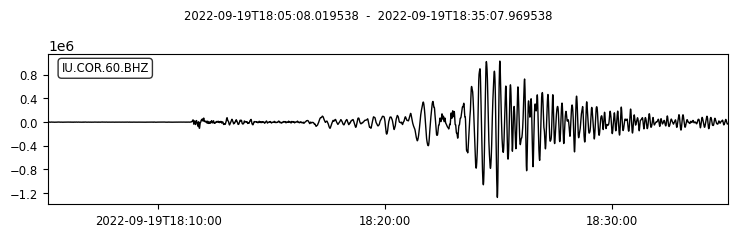

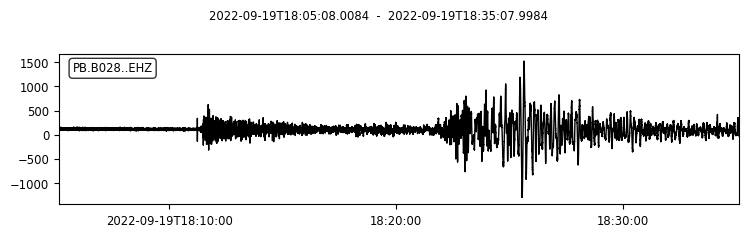

In [36]:
st1.plot();
st2.plot();

_Q8: These two station are located close to each other and record the same earthquake.  Why do the records look so different?_

Your answer here

Now let's correct for the response to estimate the true ground velocity at each station.  This is easy with obspy.

In [37]:
st1.remove_response(output='VEL')
st2.remove_response(output='VEL')

1 Trace(s) in Stream:
PB.B028..EHZ | 2022-09-19T18:05:08.008400Z - 2022-09-19T18:35:07.998400Z | 100.0 Hz, 180000 samples

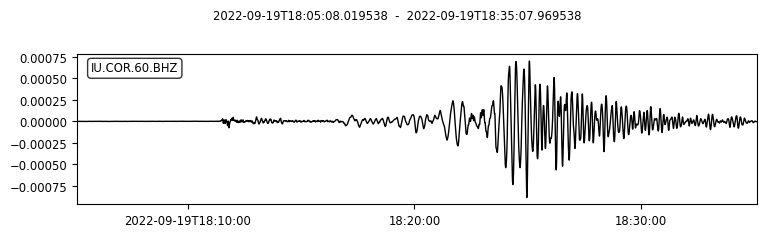

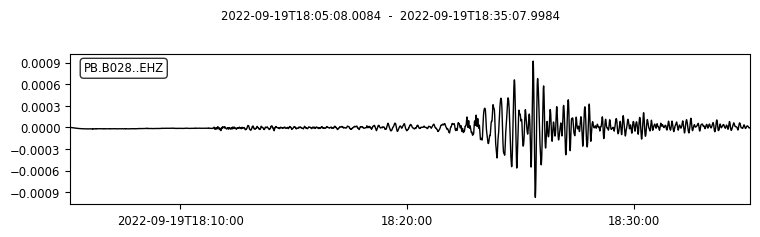

In [38]:
st1.plot();
st2.plot();

These are more similar.  They're not quite the same, as the stations are not quite in the same place, and station PB.B028 can't reconstruct things it didn't record accurately: the long period signal.

### 7.  Units

Finally, we can at least consider the units of the data.  Usually it's output in m/s if we've asked for velocity and in m if we've asked for displacement.  But let's check.  The first unit in the response is the unit.

_Q8: Which units should be on the y-axis in the plots above?_

Your answer here

In [39]:
print(st1[0].stats.response)

Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.43824e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 3429
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 419430
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


You can add units to your plots with the approach below.

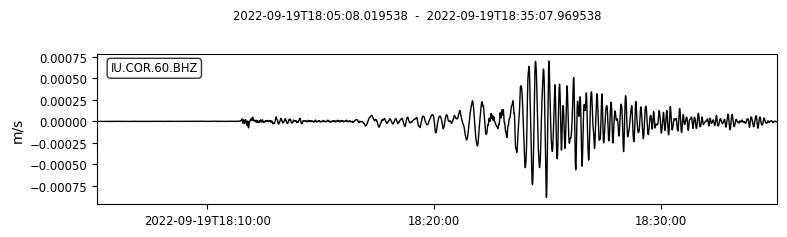

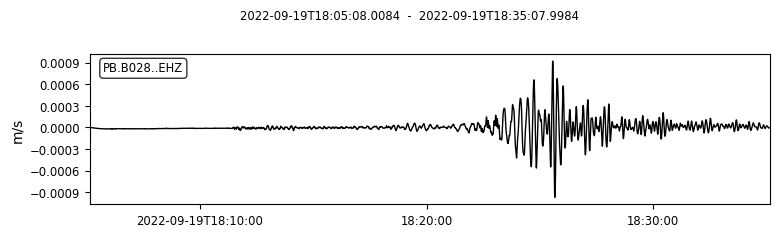

In [43]:
h=st1.plot(handle=True);
h.gca().set_ylabel('m/s');
h=st2.plot(handle=True);
h.gca().set_ylabel('m/s');


### 8. Prefiltering

We can now download data and correct for the response.  However, if the response is near-zero at a given frequency, we will not be able to reconstruct any information there.  As a result, we normally pre-filter when we do the response correction; we remove very low frequencies.  

For instance, station PB.B028 has little information at periods below 1 Hz, we filter out frequencies before 0.1 Hz before the response correction.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


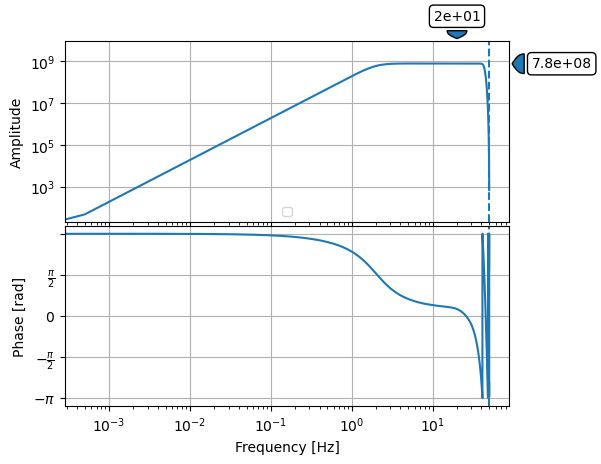

In [44]:
inventory2[0][0][0].response.plot(min_freq=0.0005);

In [45]:
# this time let's try downloading the data and response separately
st2 = client.get_waveforms("PB", "B028", "*", "EHZ", t1, t2,attach_response=False)

1 Trace(s) in Stream:
PB.B028..EHZ | 2022-09-19T18:05:08.008400Z - 2022-09-19T18:35:07.998400Z | 100.0 Hz, 180000 samples

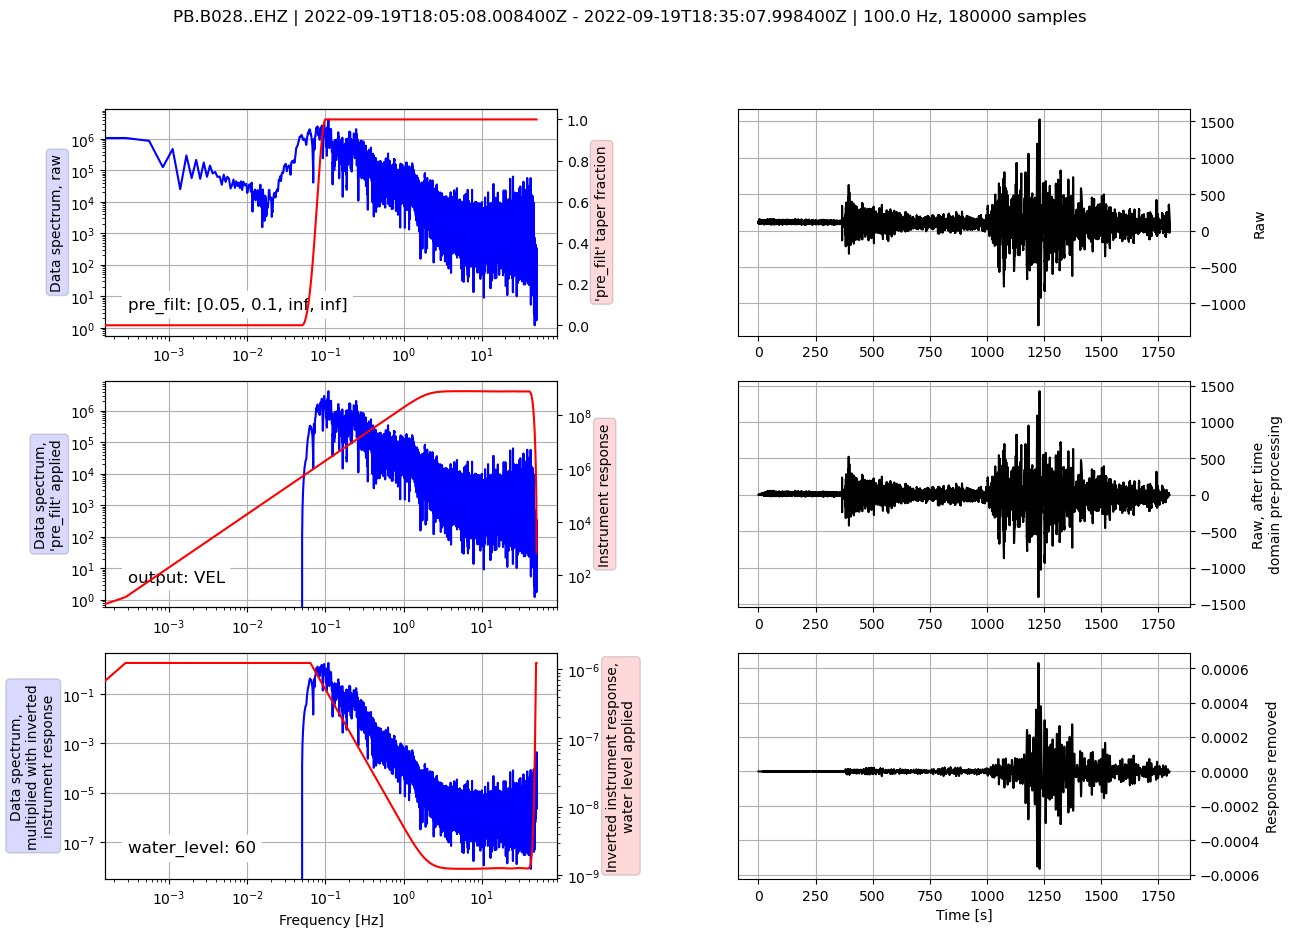

In [46]:
# this time we specify the response to use: inventory=inventory2

# and we'll specify a pre-filter: [0.005, 0.01, float('inf'),float('inf')]
# that means that we'll remove all information below 0.005 Hz
# we'll keep all information above 0.01 Hz
# and we'll remove a part of the signal in between
# this is specified by the red curve in the plot below

# indeed, here we've asked for a plot to illustrate the steps of the response correction
st2.remove_response(output='VEL',pre_filt=[0.05,0.1,float('inf'),float('inf')],
                    inventory=inventory2,plot=True)

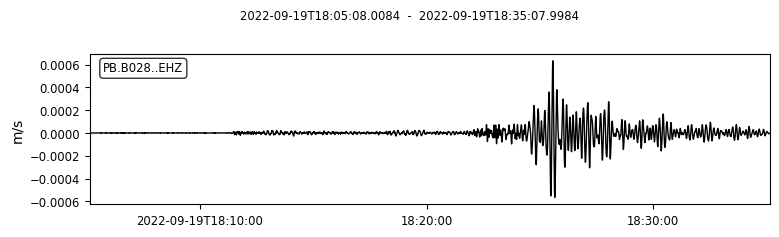

In [48]:
h=st2.plot(handle=True);
h.gca().set_ylabel('m/s');